In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline

In [18]:
!wget -O female.csv https://api.dane.gov.pl/resources/54110,lista-imion-zenskich-w-rejestrze-pesel-stan-na-19012024-imie-pierwsze/csv
!wget -O male.csv https://api.dane.gov.pl/resources/54109,lista-imion-meskich-w-rejestrze-pesel-stan-na-19012023-imie-pierwsze/csv


--2024-04-04 11:59:58--  https://api.dane.gov.pl/resources/54110,lista-imion-zenskich-w-rejestrze-pesel-stan-na-19012024-imie-pierwsze/csv
Resolving api.dane.gov.pl (api.dane.gov.pl)... 185.41.93.178
Connecting to api.dane.gov.pl (api.dane.gov.pl)|185.41.93.178|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://api.dane.gov.pl/media/resources/20240126/8_-_Wykaz_imion_%C5%BCe%C5%84skich_os%C3%B3b_%C5%BCyj%C4%85cych_wg_pola_imi%C4%99_pierwsze_wyst%C4%99puj%C4%85cych_w_rejestrze_PESEL_bez_zgon%C3%B3w.csv [following]
--2024-04-04 11:59:59--  https://api.dane.gov.pl/media/resources/20240126/8_-_Wykaz_imion_%C5%BCe%C5%84skich_os%C3%B3b_%C5%BCyj%C4%85cych_wg_pola_imi%C4%99_pierwsze_wyst%C4%99puj%C4%85cych_w_rejestrze_PESEL_bez_zgon%C3%B3w.csv
Reusing existing connection to api.dane.gov.pl:443.
HTTP request sent, awaiting response... 200 OK
Length: 469975 (459K) [application/octet-stream]
Saving to: ‘female.csv’

female.csv          100%[===================>

In [19]:
def filter_names_by_threshold(filename, threshold):
    names = []
    with open(filename, 'r', encoding='utf8') as file:
        lines = file.read().splitlines()
        for line in lines[1:]:
            entry = line.split(",")
            if int(entry[2]) > threshold:
                names.append(entry[0])
    return names



femaleNames = filter_names_by_threshold('female.csv', 20)
print("Female names number with a number greater than 100: " + str(len(femaleNames)))
print(femaleNames[:8])

maleNames = filter_names_by_threshold('male.csv', 20)
print("Male names number with a number greater than 100: " + str(len(maleNames)))
print(maleNames[:8])

Female names number with a number greater than 100: 3708
['ANNA', 'KATARZYNA', 'MARIA', 'MAŁGORZATA', 'AGNIESZKA', 'BARBARA', 'EWA', 'MAGDALENA']
Male names number with a number greater than 100: 5269
['PIOTR', 'KRZYSZTOF', 'TOMASZ', 'ANDRZEJ', 'PAWEŁ', 'MICHAŁ', 'JAN', 'MARCIN']


In [20]:
def has_polish_or_english_chars(name):
    polish_chars = 'ĄĆĘŁŃÓŚŹŻABCDEFGHIJKLMNOPQRSTUVWXYZ'
    return all(char in polish_chars for char in name)

#source=femaleNames+maleNames
source=femaleNames
print("Combined names number: "+str(len(source)))
#Lets filter out names with spaces because those can be aproximated as 2 names

words= list(filter(lambda x: ' ' not in x, source))
print("Filtered names number: "+str(len(words)))
words= list(filter(lambda x: has_polish_or_english_chars(x), words))
print("Filtered names number: "+str(len(words)))
random.shuffle(words)

words[:10]
#wierdNames=list(filter(lambda x: ' ' in x, source))
#wierdNames[:8]

Combined names number: 3708
Filtered names number: 3646
Filtered names number: 3517


['LUDWIKA',
 'NADZIEJA',
 'SOLOMIJA',
 'SŁAWA',
 'OSNAT',
 'RINATA',
 'NAZIRA',
 'LOUISA',
 'KASJANA',
 'ALIZA']

In [21]:
b = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

In [22]:
sorted(b.items(), key = lambda kv: -kv[1])[:8]

[(('A', '<E>'), 2387),
 (('N', 'A'), 820),
 (('A', 'N'), 675),
 (('I', 'A'), 473),
 (('L', 'I'), 470),
 (('<S>', 'A'), 457),
 (('E', 'L'), 406),
 (('I', 'N'), 404)]

In [23]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [24]:
VOCAB_SIZE=len(chars)+1
N = torch.zeros((34, 34), dtype=torch.int32)

In [25]:

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1


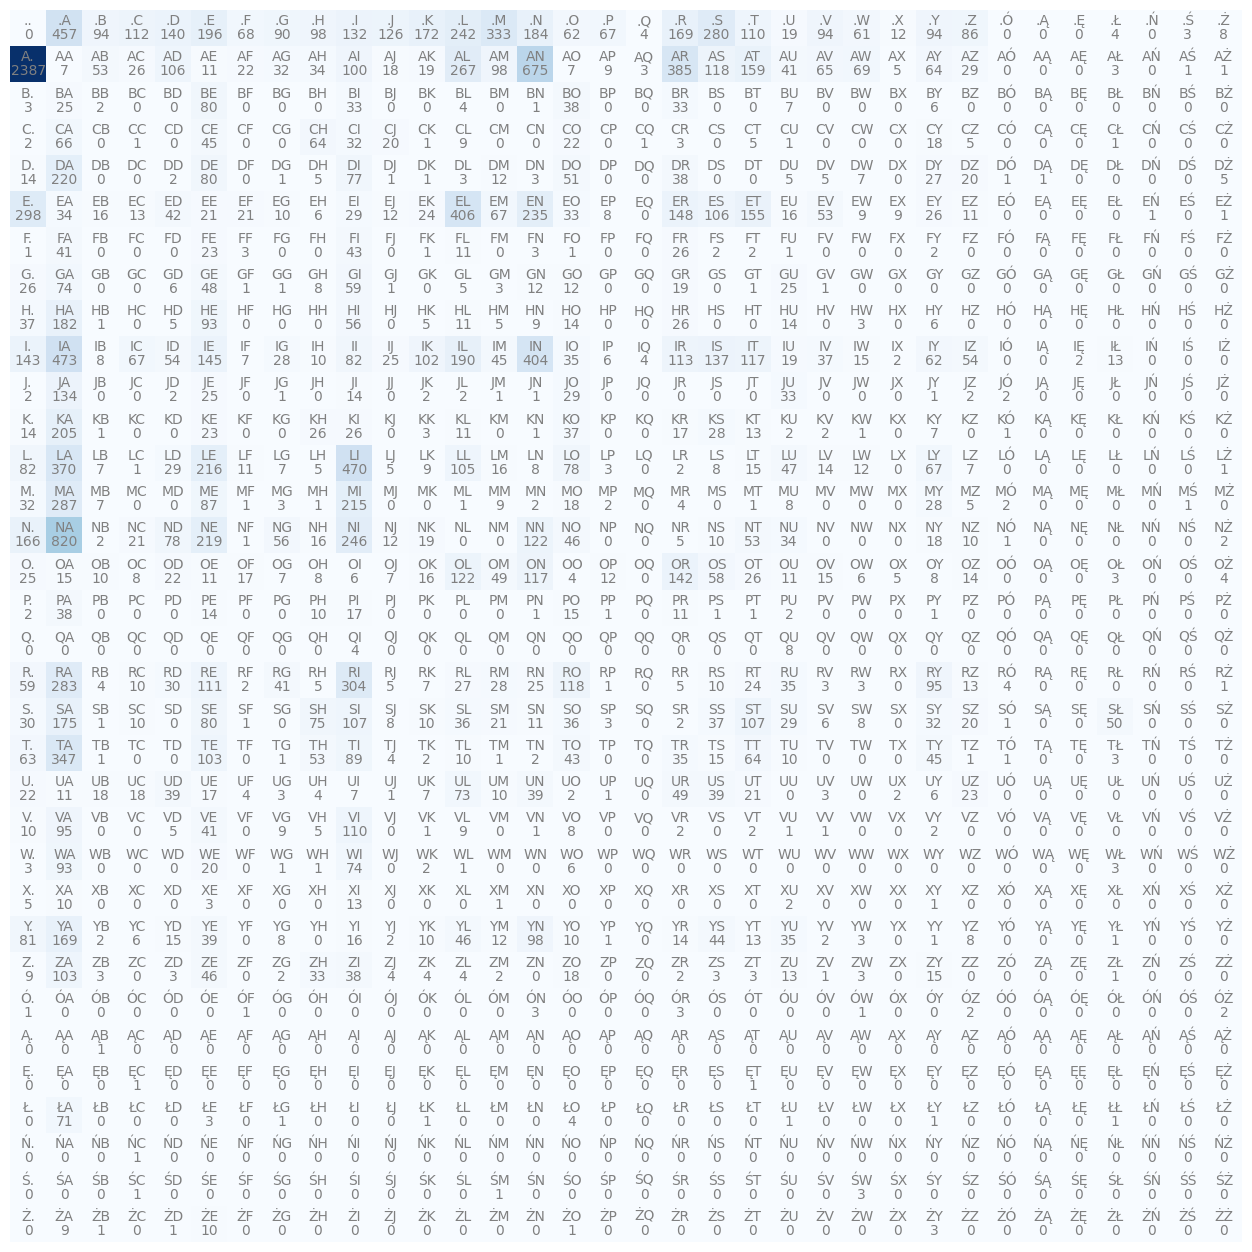

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(VOCAB_SIZE):
    for j in range(VOCAB_SIZE):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [29]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((VOCAB_SIZE, VOCAB_SIZE), generator=g, requires_grad=True)

number of examples:  25463


In [35]:
# gradient descent
for k in range(100):

  # forward pass
  xenc = F.one_hot(xs, num_classes=VOCAB_SIZE).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

2.4364752769470215
2.440140724182129
2.43646240234375
2.4401276111602783
2.4364500045776367
2.440115213394165
2.4364373683929443
2.4401025772094727
2.43642520904541
2.4400901794433594
2.436412811279297
2.440078020095825
2.4364006519317627
2.440066337585449
2.4363887310028076
2.440054178237915
2.4363768100738525
2.440042018890381
2.4363646507263184
2.440030813217163
2.4363534450531006
2.440019130706787
2.4363417625427246
2.440007448196411
2.4363303184509277
2.4399960041046143
2.436318874359131
2.4399852752685547
2.436307907104492
2.439974069595337
2.4362969398498535
2.4399631023406982
2.4362854957580566
2.4399518966674805
2.436274766921997
2.439941167831421
2.4362642765045166
2.4399309158325195
2.436253547668457
2.439919948577881
2.4362430572509766
2.4399094581604004
2.436232805252075
2.439899206161499
2.4362223148345947
2.4398891925811768
2.4362120628356934
2.4398787021636963
2.436201572418213
2.439868688583374
2.4361917972564697
2.4398584365844727
2.4361817836761475
2.4398491382598877

In [36]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:

    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=VOCAB_SIZE).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

JUNIDEDIANASAR.
PANGAY.
A.
NAR.
SIINITOLIANANGET.
